In [1]:
import numpy as np

from utils import iteration_logging
from graph_cycle_iterator import GraphCycleIterator
from graph_edge_iterator import GraphEdgeIterator
from tqdm.auto import tqdm
import io
import pandas as pd

In [2]:

OMEGA = 10
BUFFER_COUNT = 2
PRUNE_INTERVAL = 1_000
END_DATE = None #"2019-08-10"
TOTAL_EDGES = len(list(GraphEdgeIterator(end_date=END_DATE, buffer_count=BUFFER_COUNT)))

In [ ]:

csv_stream = io.StringIO()

wrapped_edges = GraphCycleIterator(
    tqdm(  # type: ignore
        iteration_logging(
            GraphEdgeIterator(end_date=END_DATE, buffer_count=BUFFER_COUNT),
            log_stream=csv_stream,
        ),
        total=TOTAL_EDGES,
        desc="Edges",
    ),
    omega=OMEGA,
    prune_interval=PRUNE_INTERVAL
)

wrapped_edges.run()



Edges:   0%|          | 0/2912276 [00:00<?, ?it/s]

array([<Axes: xlabel='time_seconds'>, <Axes: xlabel='time_seconds'>,
       <Axes: xlabel='time_seconds'>], dtype=object)

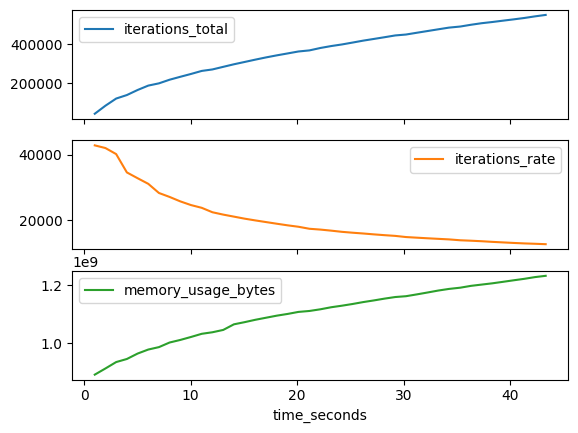

In [4]:
csv_stream.seek(0)
df = pd.read_csv(csv_stream)
df = df.set_index("time_seconds")
df.plot(subplots=True)

In [5]:
sum(len(intervals) for intervals in wrapped_edges.seeds.values())

18